In [12]:
%pip install -r ../requirements.txt -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [3]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [4]:
from bertviz import head_view

In [7]:
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display

In [13]:
%matplotlib inline
%matplotlib widget

In [14]:
model_name = "distilbert-base-uncased-finetuned-sst-2-english"

In [15]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    output_hidden_states=True,
    output_attentions=True
)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [16]:
text = "im sad because you are accusing me of this paradigm"
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)

with torch.no_grad():
    outputs = model(**inputs)

probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
predicted_class = torch.argmax(probs, dim=-1).numpy()[0]

class_names = ['negative', 'positive']
print(f"Predicted class: {class_names[predicted_class]}")

Predicted class: negative


In [17]:
def get_reduced_embeddings(hidden_states, layer, tokenized_text, n_components=2):
    assert layer <= len(hidden_states), f"WARNING: expected layer_id to be <= {len(hidden_states)}, found layer_id={layer}"
    
    layer_embeddings = hidden_states[layer].squeeze(0).numpy()

    pca = PCA(n_components=n_components)
    reduced_embeddings = pca.fit_transform(layer_embeddings)

    return reduced_embeddings

In [18]:
def plot_embeddings(embeds, tokens, layer, dimensions=2):
    assert dimensions in [2, 3], "dimensions parameter must be 2 or 3"

    plt.figure(figsize=(5, 5))
    
    if dimensions == 3:
        ax = plt.axes(projection='3d')
        ax.scatter3D(embeds[:, 0], embeds[:, 1], embeds[:, 2])
    else:
        plt.scatter(embeds[:, 0], embeds[:, 1], c='blue', marker='o')
    
    for i, token in enumerate(tokens):
        if dimensions == 3:
            ax.text(embeds[i, 0], embeds[i, 1], embeds[i, 2], token)
        else:
            plt.annotate(token, (embeds[i, 0]+0.25, embeds[i, 1]+0.25))

    
    plt.title(f'Layer {layer} Embedding')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    
    if dimensions == 3:
        ax.set_zlabel('PCA 3')
        
    plt.grid(True, alpha=0.75)
    plt.show()

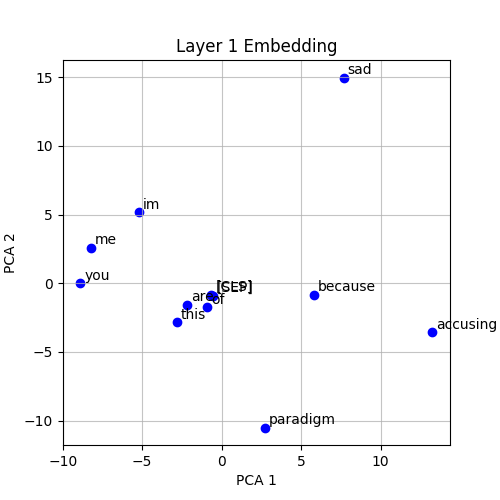

In [19]:
hidden_states = outputs.hidden_states
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

layer = 1
n_components = 2
embeds = get_reduced_embeddings(
    hidden_states=hidden_states, 
    layer=layer, 
    tokenized_text=tokens, 
    n_components=n_components
)
plot_embeddings(embeds, tokens, layer, dimensions=n_components)

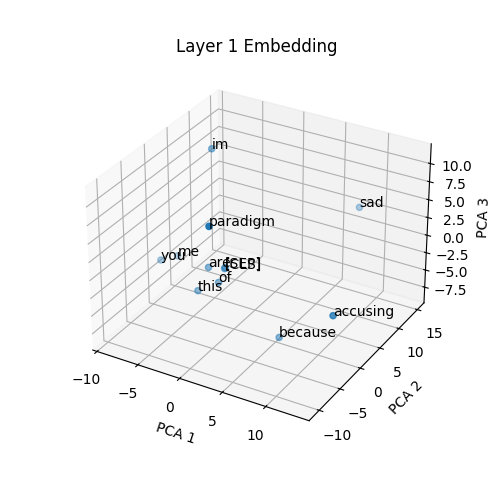

In [20]:
hidden_states = outputs.hidden_states
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

layer = 1
n_components = 3
embeds = get_reduced_embeddings(
    hidden_states=hidden_states, 
    layer=layer, 
    tokenized_text=tokens, 
    n_components=n_components
)
plot_embeddings(embeds, tokens, layer, dimensions=n_components)

In [21]:
def plot_embeddings_interactive(embeds, tokens, title):
    fig = go.Figure(data=[go.Scatter3d(
        x=embeds[:, 0],
        y=embeds[:, 1],
        z=embeds[:, 2],
        
        mode='markers+text',
        text=tokens,
        textposition='top center',
        
        marker=dict(
            size=5,  
            color='blue',
            opacity=0.8  
        )
    )])

    grid_color = 'rgba(0, 0, 0, 0.2)'
    
    fig.update_layout(
        title=dict(
            text=title,
            y=0.96
        ),
        scene=dict(
            xaxis_title='PCA 1',
            yaxis_title='PCA 2',
            zaxis_title='PCA 3',
            xaxis=dict(showgrid=True, gridcolor=grid_color, gridwidth=4),
            yaxis=dict(showgrid=True, gridcolor=grid_color, gridwidth=4),
            zaxis=dict(showgrid=True, gridcolor=grid_color, gridwidth=4)
        ),
        margin=dict(l=10, r=10, b=10, t=0),
        autosize=False,
        width=600,
        height=600
    )

    fig.show()

In [22]:
hidden_states = outputs.hidden_states
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

layer_num = 4
n_components = 3
embeds = get_reduced_embeddings(
    hidden_states=hidden_states, 
    layer=layer_num, 
    tokenized_text=tokens, 
    n_components=n_components
)
plot_embeddings_interactive(embeds, tokens, f'Layer {layer_num} Embedding')

In [23]:
attention = outputs.attentions
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])


head_view(attention, tokens)

<IPython.core.display.Javascript object>

In [24]:
def per_head_attention(attentions, layer_num):
    # (N_layers, B, H, N, N)
    attentions = attentions[layer_num][0]
    return attentions


def aggregate_attention(attentions, layer_num):
    # (N_layers, B, H, N, N)
    attentions = attentions[layer_num][0]
    aggregated_attention = layer_attention.mean(dim=0)
    return aggregated_attention

In [26]:
layer_num = 5

aggregated_attention = aggregate_attention(outputs.attentions, layer_num)
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])


plt.figure(figsize=(5, 5))

sns.heatmap(aggregated_attention.detach().numpy(), 
            xticklabels=tokens, yticklabels=tokens, cmap="jet", cbar=False)


plt.title(f"Aggregated Attention Heatmap (Layer {layer_num})")
plt.show()

NameError: name 'layer_attention' is not defined

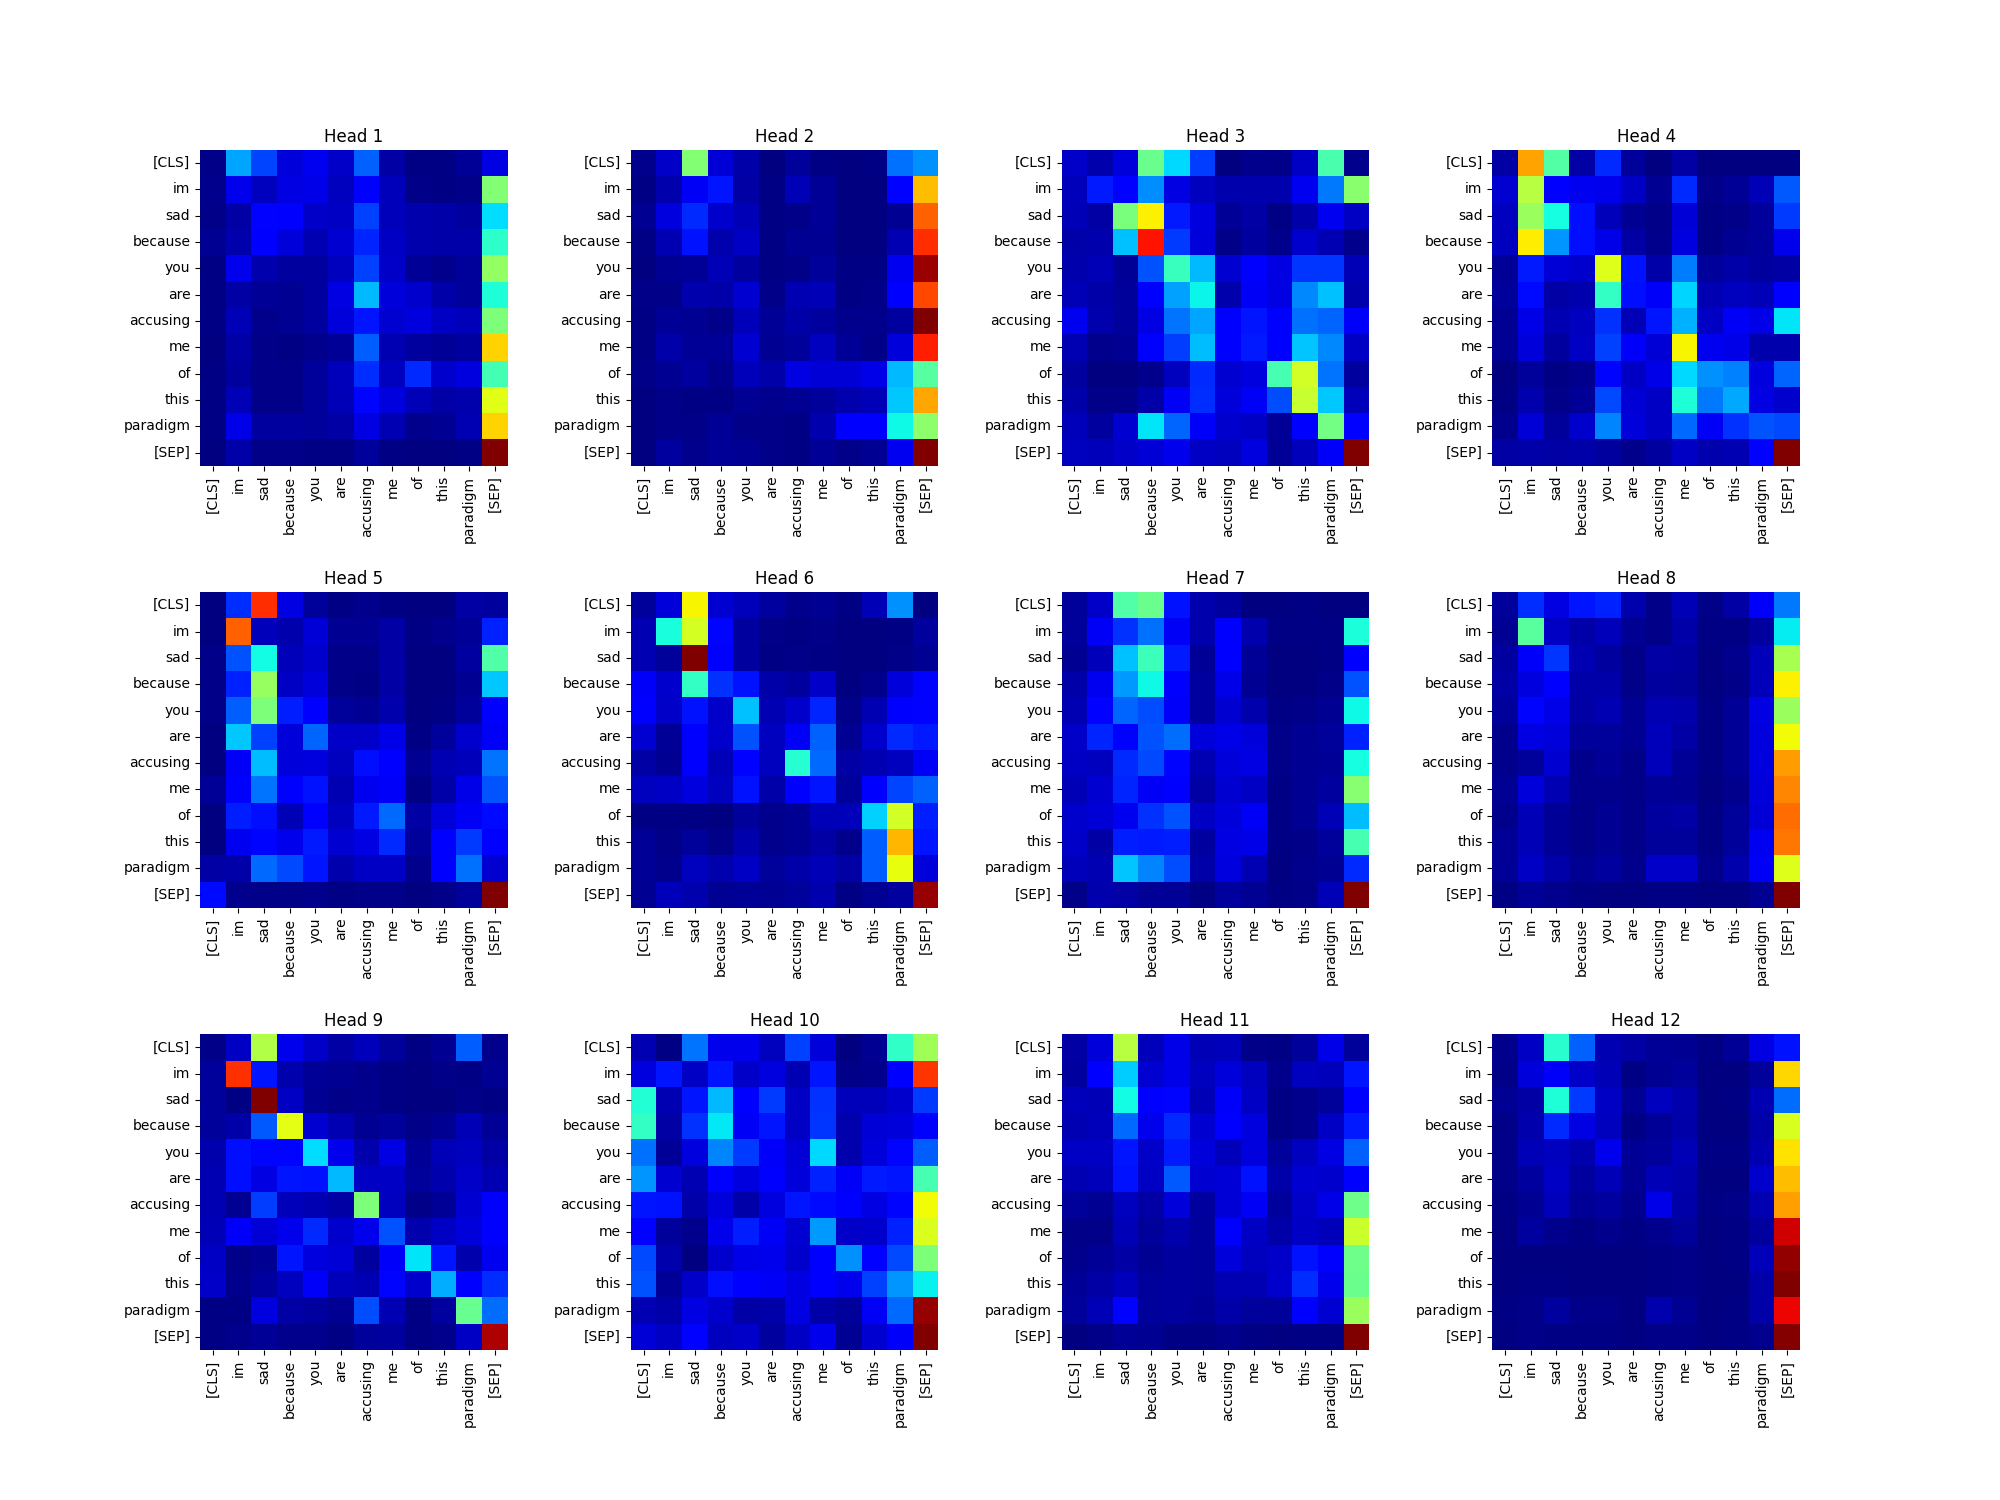

In [27]:
layer_num = 5

layer_attentions = per_head_attention(outputs.attentions, layer_num)
num_heads = layer_attentions.size(0)
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

# sen. sen. 
heads_per_row = 4
fig, axes = plt.subplots(num_heads//heads_per_row, heads_per_row, figsize=(20, 15))

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

for i in range(num_heads):
    row = i // heads_per_row
    col = i % heads_per_row
    ax = axes[row, col]

    sns.heatmap(layer_attentions[i].detach().numpy(), ax=ax, 
                xticklabels=tokens, yticklabels=tokens, cmap="jet", cbar=False)
    ax.set_title(f'Head {i + 1}')

In [ ]:
# Experimental

In [28]:
def get_token_trajectory(hidden_states, token_index, n_components=3):
    trajectory = []
    for layer in hidden_states:
        layer_embeddings = layer.squeeze(0).numpy()
        pca = PCA(n_components=n_components)
        reduced_embeddings = pca.fit_transform(layer_embeddings)
        trajectory.append(reduced_embeddings[token_index])
    return np.array(trajectory)


def plot_token_trajectory(embeds, trajectory, tokens, title):
    fig = go.Figure()

    fig.add_trace(go.Scatter3d(
        x=embeds[:, 0],
        y=embeds[:, 1],
        z=embeds[:, 2],
        mode='markers',
        marker=dict(size=5, color='blue', opacity=0.8),
        name='Embeddings'
    ))

    
    fig.add_trace(go.Scatter3d(
        x=trajectory[:, 0],
        y=trajectory[:, 1],
        z=trajectory[:, 2],
        mode='lines+markers',
        marker=dict(size=5, color='red', opacity=0.8),
        line=dict(color='red', width=2),
        name='Token Trajectory'
    ))

    
    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title='PCA 1',
            yaxis_title='PCA 2',
            zaxis_title='PCA 3'
        ),
        margin=dict(l=10, r=10, b=10, t=30),
        width=800,
        height=600
    )

    fig.show()

In [29]:
token_to_track = 'sad' 
token_index = tokens.index(token_to_track)

layer_num = len(hidden_states) - 1
embeds = get_reduced_embeddings(hidden_states, layer_num, tokens, n_components=3)
trajectory = get_token_trajectory(hidden_states, token_index, n_components=3)

plot_token_trajectory(embeds, trajectory, tokens, f'Trajectory of "{token_to_track}" Across Layers')

In [30]:
data = {
    "Environmental Conservation": {
        "sequence_1": {
            "Positive": {
                "iteration_1": "The community's tree-planting event last Saturday led to the planting of over 300 saplings in the local park.",
                "iteration_2": "Local initiatives are increasingly focusing on enhancing green spaces in urban areas.",
                "iteration_3": "Communities are becoming more involved in environmental protection activities.",
                "iteration_4": "Public participation in conservation efforts is on the rise globally.",
                "iteration_5": "Global awareness and action towards environmental conservation are growing."
            },
            "Negative": {
                "iteration_1": "The river near my house has been polluted due to industrial waste dumping, killing most of the fish.",
                "iteration_2": "Water bodies are frequently being contaminated by industrial activities in many regions.",
                "iteration_3": "Pollution from industrial processes is a growing environmental concern.",
                "iteration_4": "Human industrial activities are increasingly harming the natural environment.",
                "iteration_5": "There is a global trend of environmental degradation due to human actions."
            }
        }
    },
    
    "Technology Advancements": {
        "sequence_1": {
            "Positive": {
                "iteration_1": "The new AI software I installed has significantly sped up data analysis tasks at my job.",
                "iteration_2": "Advanced software solutions are enhancing productivity in many workplaces.",
                "iteration_3": "Innovative technologies are transforming the professional landscape.",
                "iteration_4": "Technological innovation is leading to increased efficiency across various sectors.",
                "iteration_5": "The rise of advanced technology is reshaping global economic and social structures."
            },
            "Negative": {
                "iteration_1": "I'm overwhelmed by the constant software updates required for my phone and computer.",
                "iteration_2": "Frequent technology upgrades are becoming a hassle for many consumers.",
                "iteration_3": "The rapid pace of technological change can be stressful and alienating.",
                "iteration_4": "There is a growing concern over the societal impact of continuous technological disruption.",
                "iteration_5": "The relentless advancement of technology raises questions about sustainability and human well-being."
            }
        }
    },

    "Health and Fitness": {
        "sequence_1": {
            "Positive": {
                "iteration_1": "My new fitness tracker motivated me to achieve 10,000 steps daily, improving my overall health.",
                "iteration_2": "Wearable fitness technology is helping individuals monitor and improve their physical activity.",
                "iteration_3": "Digital health tools are playing a crucial role in promoting healthier lifestyles.",
                "iteration_4": "The integration of technology in fitness and health is enhancing personal well-being.",
                "iteration_5": "Technological advancements in health and fitness are contributing to improved public health outcomes."
            },
            "Negative": {
                "iteration_1": "I find the constant health notifications from my smartwatch to be anxiety-inducing.",
                "iteration_2": "For some, the over-reliance on health monitoring devices can lead to unnecessary stress.",
                "iteration_3": "The obsession with digital health metrics can detract from holistic well-being.",
                "iteration_4": "There's a growing concern about the psychological effects of excessive fitness tracking.",
                "iteration_5": "The pervasive nature of health technology raises questions about its impact on mental health."
            }
        }
    },


    "Urban Development": {
        "sequence_1": {
            "Positive": {
                "iteration_1": "The city has constructed 50 new public parks this year, enhancing green spaces for residents.",
                "iteration_2": "A significant increase in urban green spaces is contributing to better living conditions in the city.",
                "iteration_3": "Expanding urban greenery is a key factor in improving city life.",
                "iteration_4": "Urban development is increasingly focusing on environmental sustainability.",
                "iteration_5": "Sustainable urban planning is becoming essential for modern cities."
            },
            "Negative": {
                "iteration_1": "25% of local shops have closed due to the new mega mall development in the city center.",
                "iteration_2": "The rise of large shopping centers is threatening small businesses in urban areas.",
                "iteration_3": "Urban commercialization is altering the traditional retail landscape.",
                "iteration_4": "The character of city centers is changing due to corporate urban development.",
                "iteration_5": "The evolution of urban spaces reflects broader economic and social shifts."
            }
        }
    },

    "Educational Advances": {
        "sequence_1": {
            "Positive": {
                "iteration_1": "This semester, our school introduced 20 new online courses, greatly expanding learning opportunities.",
                "iteration_2": "The addition of diverse online courses is enhancing educational accessibility.",
                "iteration_3": "Digital platforms are revolutionizing the way education is delivered.",
                "iteration_4": "Educational technology is bridging gaps in traditional education systems.",
                "iteration_5": "The evolution of learning methods is reshaping the educational landscape globally."
            },
            "Negative": {
                "iteration_1": "30% of students reported difficulties in adapting to online learning platforms.",
                "iteration_2": "The transition to digital education poses challenges for a significant portion of students.",
                "iteration_3": "Not all students have equal access to the necessary technology for online learning.",
                "iteration_4": "Digital divide issues are becoming more apparent in the education sector.",
                "iteration_5": "Educational inequality is a growing concern in the era of digital learning."
            }
        }
    },

    "Environmental Awareness": {
        "sequence_1": {
            "Positive": {
                "iteration_1": "Our community recycled over 500 tons of waste last year, setting a new record.",
                "iteration_2": "Increased recycling efforts are significantly reducing community waste.",
                "iteration_3": "Recycling initiatives are crucial in promoting sustainable living practices.",
                "iteration_4": "Sustainable waste management is gaining momentum in communities worldwide.",
                "iteration_5": "Global environmental awareness is leading to more responsible waste management."
            },
            "Negative": {
                "iteration_1": "Despite efforts, plastic waste in the ocean increased by 10% this year.",
                "iteration_2": "Ocean pollution continues to rise, challenging environmental conservation efforts.",
                "iteration_3": "Marine ecosystems are increasingly threatened by human-generated waste.",
                "iteration_4": "The ongoing pollution crisis poses a serious threat to global marine life.",
                "iteration_5": "Environmental challenges in marine conservation reflect broader global issues."
            }
        }
    },


    "Public Health Initiatives": {
        "sequence_1": {
            "Positive": {
                "iteration_1": "The city vaccinated 200,000 residents against the flu in a recent campaign, surpassing its goal.",
                "iteration_2": "Large-scale vaccination drives are proving effective in combating seasonal illnesses.",
                "iteration_3": "Public health campaigns are playing a key role in disease prevention.",
                "iteration_4": "Nationwide initiatives are enhancing the overall health security of the population.",
                "iteration_5": "Global efforts in public health are crucial for combating widespread health challenges."
            },
            "Negative": {
                "iteration_1": "40% of the targeted demographic missed the latest health screening event due to lack of awareness.",
                "iteration_2": "Inadequate public health communication is leading to lower participation in preventive programs.",
                "iteration_3": "Challenges in public health messaging are impacting prevention effectiveness.",
                "iteration_4": "There is a growing need for better health education and outreach strategies.",
                "iteration_5": "Effective communication is a critical component of successful public health initiatives."
            }
        }
    },

    "Space Exploration": {
        "sequence_1": {
            "Positive": {
                "iteration_1": "The recent mission successfully deployed 5 satellites into orbit, enhancing global communication networks.",
                "iteration_2": "Satellite launches are increasingly contributing to advancements in global connectivity.",
                "iteration_3": "Space missions are essential in driving technological progress in communication.",
                "iteration_4": "The exploration of space is leading to groundbreaking developments in various technologies.",
                "iteration_5": "Space exploration represents a frontier for innovation and discovery."
            },
            "Negative": {
                "iteration_1": "The latest rocket launch produced over 300 tons of carbon emissions, raising environmental concerns.",
                "iteration_2": "Space launches have a significant environmental impact due to their high carbon footprint.",
                "iteration_3": "The environmental cost of space missions is becoming a critical issue.",
                "iteration_4": "Balancing space exploration with environmental sustainability is a growing challenge.",
                "iteration_5": "The pursuit of space exploration must consider long-term ecological implications."
            }
        }
    },
}

In [31]:
from scipy.spatial.distance import cosine

In [32]:
def get_sentence_embedding(sentence, model, tokenizer, level):
    inputs = tokenizer(sentence, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)

    embeddings = outputs.hidden_states[level] 
    
    return embeddings.mean(dim=1).squeeze().detach().numpy() 

In [33]:
def get_all_sentence_embeddings(sentences, model, tokenizer, level):
    return [get_sentence_embedding(sentence, model, tokenizer, level) for sentence in sentences]

In [34]:
def aggregate_distances(data, model, tokenizer, level):
    all_distances = {f'iteration_{i+1}': [] for i in range(5)}

    for category, sequences in data.items():
        for sentiment, iterations in sequences["sequence_1"].items():
            sentences = [iterations[f'iteration_{i+1}'] for i in range(len(iterations))]
            embeddings = get_all_sentence_embeddings(sentences, model, tokenizer, level)
            
            for i in range(0, len(embeddings)):
                distance = cosine(embeddings[0], embeddings[i])
                all_distances[f'iteration_{i+1}'].append(distance)

    return all_distances

In [35]:
all_distances = aggregate_distances(data, model, tokenizer, level=6)

In [36]:
means = []
stds = []
for iteration, distances in all_distances.items():
    means.append(np.mean(distances))
    stds.append(np.std(distances))

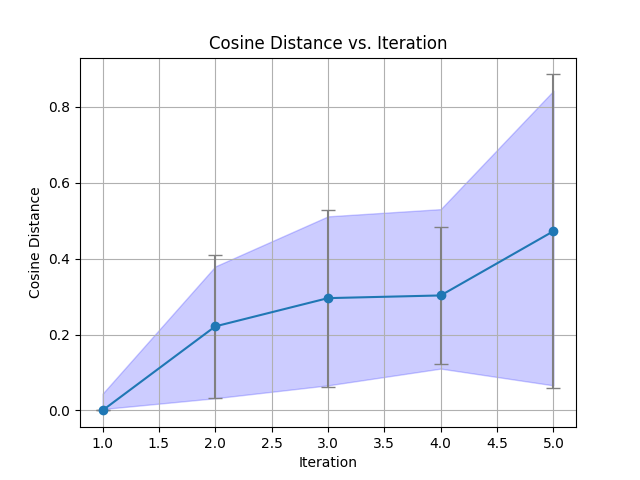

In [37]:
from scipy.ndimage import gaussian_filter1d

iterations = np.array(range(1, 6)) 
means = np.array(means) 
stds = np.array(stds)

smooth_means = gaussian_filter1d(means, sigma=0.5)
smooth_stds = gaussian_filter1d(stds, sigma=0.5)

plt.figure()

# plt.plot(iterations, means)
# plt.plot(iterations, stds)
plt.errorbar(iterations, means, yerr=stds, fmt='-o', ecolor='gray', capsize=5)
plt.fill_between(iterations, smooth_means - smooth_stds, smooth_means + smooth_stds, 
                 color="blue", alpha=0.2)

plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Cosine Distance')
plt.title('Cosine Distance vs. Iteration')
plt.show()

In [38]:
text = data["Health and Fitness"]["sequence_1"]["Negative"]["iteration_2"]
print(text)
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)

with torch.no_grad():
    outputs = model(**inputs)

probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
predicted_class = torch.argmax(probs, dim=-1).numpy()[0]

class_names = ['negative', 'positive']
print(f"Predicted class: {class_names[predicted_class]}")

For some, the over-reliance on health monitoring devices can lead to unnecessary stress.
Predicted class: negative


In [39]:
hidden_states = outputs.hidden_states
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

layer_num = 6
n_components = 3
embeds = get_reduced_embeddings(
    hidden_states=hidden_states, 
    layer=layer_num, 
    tokenized_text=tokens, 
    n_components=n_components
)
plot_embeddings_interactive(embeds, tokens, f'Layer {layer_num} Embedding')

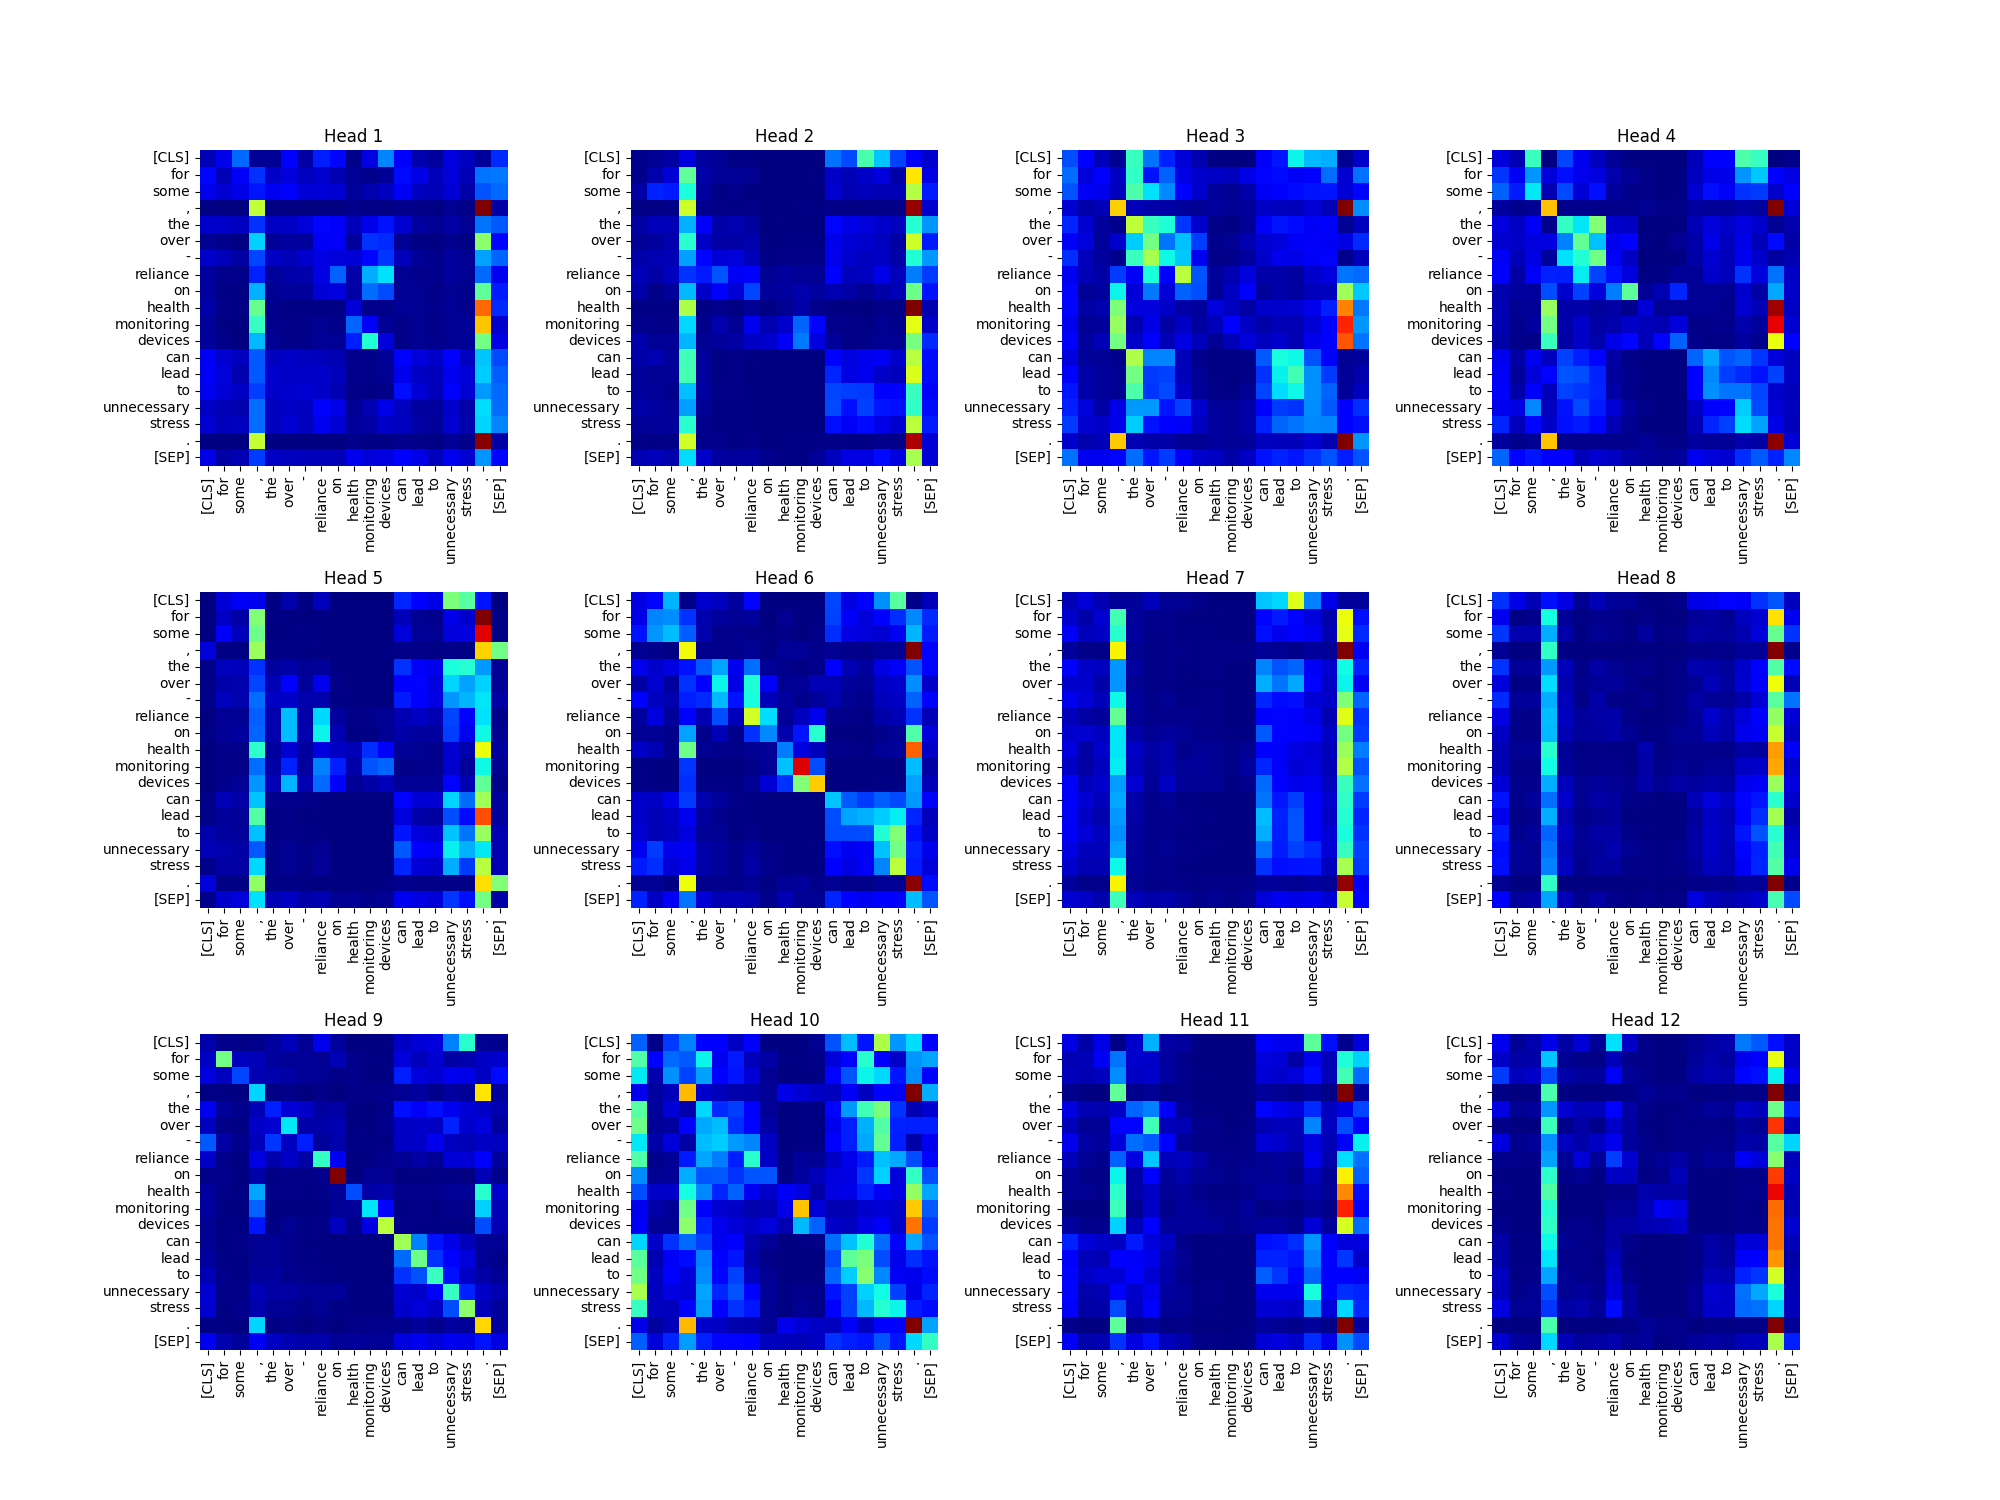

In [40]:
layer_num = 5

layer_attentions = per_head_attention(outputs.attentions, layer_num)
num_heads = layer_attentions.size(0)
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])


heads_per_row = 4
fig, axes = plt.subplots(num_heads//heads_per_row, heads_per_row, figsize=(20, 15))

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

for i in range(num_heads):
    row = i // heads_per_row
    col = i % heads_per_row
    ax = axes[row, col]

    sns.heatmap(layer_attentions[i].detach().numpy(), ax=ax, 
                xticklabels=tokens, yticklabels=tokens, cmap="jet", cbar=False)
    ax.set_title(f'Head {i + 1}')